# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [22]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error


## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [14]:
#Load your data into a pandas dataframe here
df = pd.read_csv('C:\\Users\\jegullin\\Documents\\Projects\\AAI\\AAI530\\cleaned_household_power_consumption.csv')
df.head()

,Datetime,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000
1,2006-12-16 17:25:00,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000
2,2006-12-16 17:26:00,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000
3,2006-12-16 17:27:00,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000
4,2006-12-16 17:28:00,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000


In [15]:
#convert datetime to epoch/unix time
df['unix'] = pd.to_datetime(df['Datetime']).apply(lambda x: x.timestamp())
df.head()

,Datetime,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,unix
0,2006-12-16 17:24:00,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,1166289840.00000
1,2006-12-16 17:25:00,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,1166289900.00000
2,2006-12-16 17:26:00,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,1166289960.00000
3,2006-12-16 17:27:00,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,1166290020.00000
4,2006-12-16 17:28:00,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,1166290080.00000


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph (prediction horizon) is the time period into the future for which we want to make predictions and mu is a parameter that can be used for regularization or weighting in the model.



**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [16]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 * 60 #prediction horizon in seconds
ph_index = ph / (df.unix[1] - df.unix[0])
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: The weight will be mu^(5000-1) = 0.9^4999

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [17]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):  # start out with 2 leading datapoints
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
        
    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_
    
    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

In [ ]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ?
    ys_tmp = ?
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = ?
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = ? 
    model_tmp = ?
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = ?
    q_tmp = ?

    #use ph to make the model prediction according to the prediction time
    tp = ?
    yp = ?
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

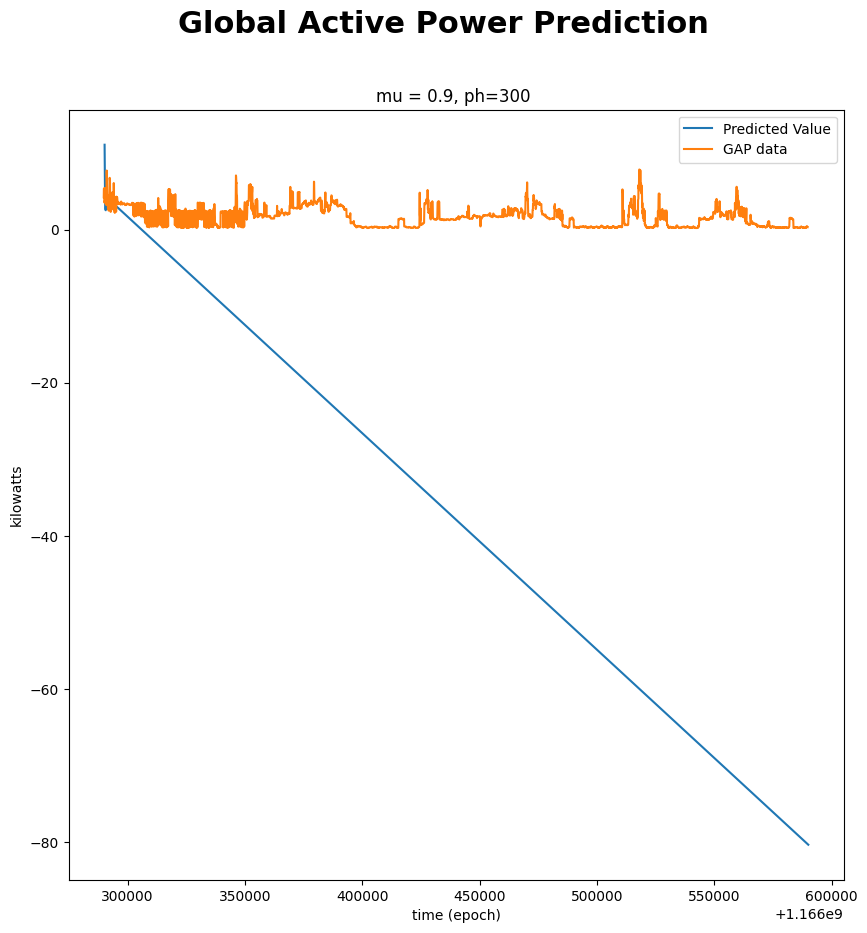

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

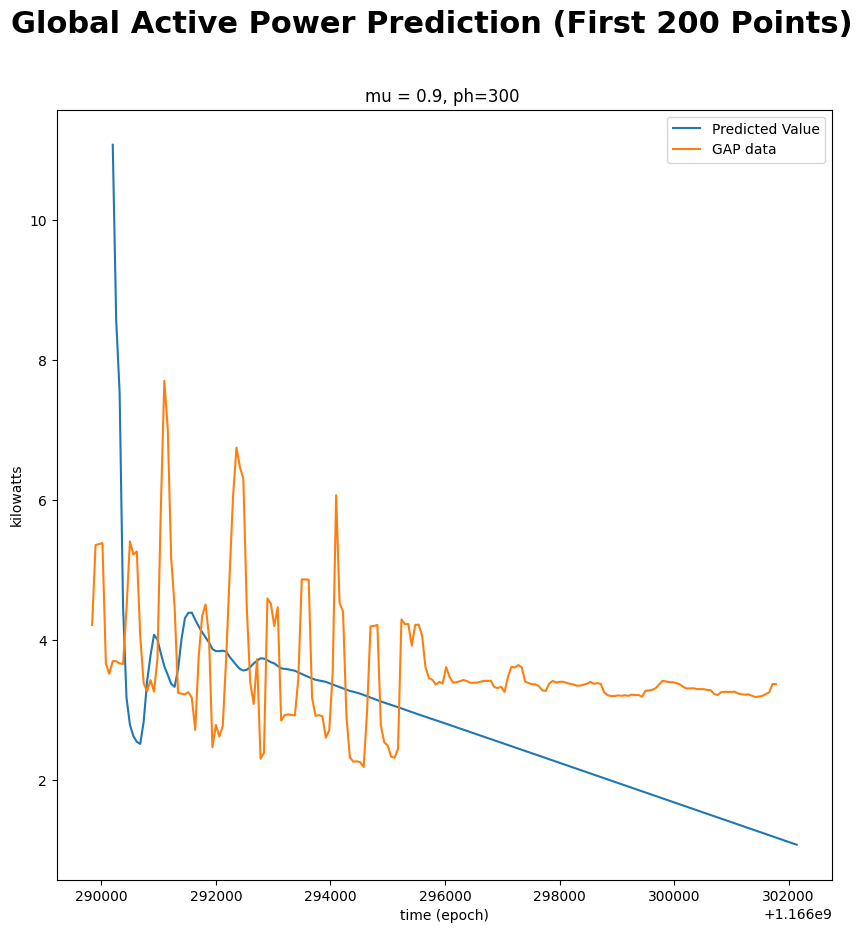

In [19]:
#Plot first 200 data points/predictions
# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200, 0], ys.iloc[0:200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

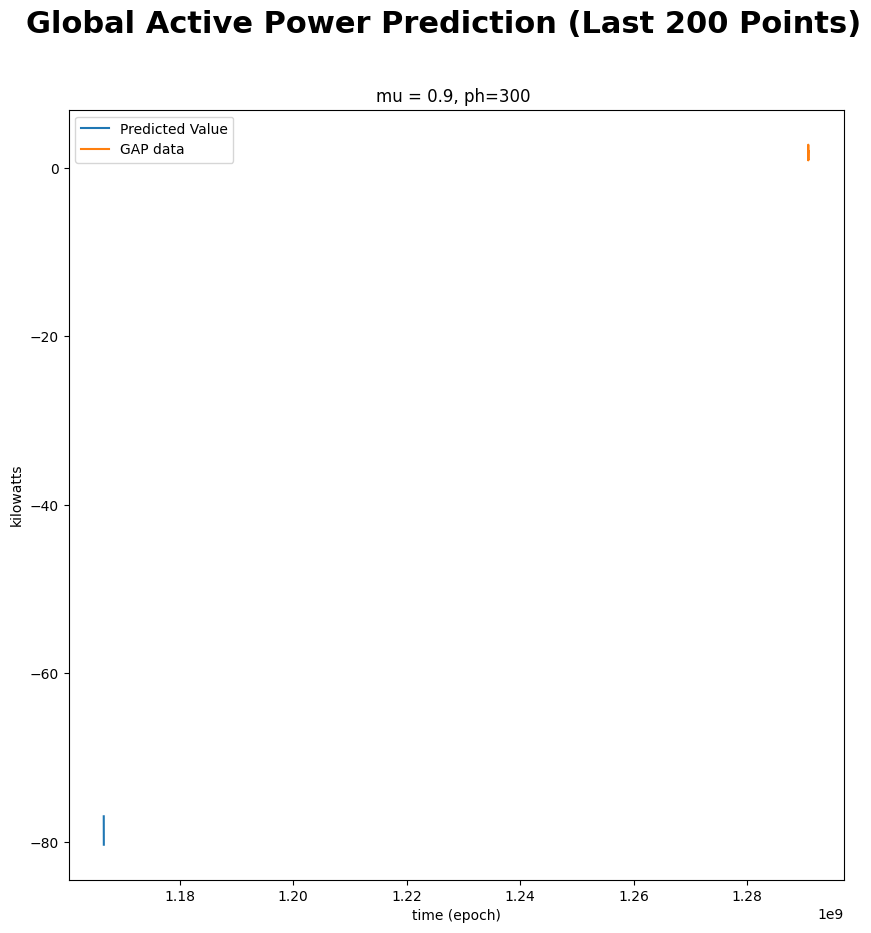

In [20]:
# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [27]:
# Calculate MSE of predictions

ys_values = ys.iloc[1:n_s, 0].values.astype(float)
yp_pred_values = yp_pred[:n_s-1].astype(float)


mse = mean_squared_error(ys_values, yp_pred_values)
print(f'Mean Squared Error of predictions: {mse}')

Mean Squared Error of predictions: 2147.918485819316


In [26]:
#Calculate MSE of predictions
mse = mean_squared_error(ys.iloc[1:n_s, 0].values, yp_pred[:n_s-1])
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

TypeError: cannot do slice indexing on RangeIndex with these indexers [5.0] of type float64

**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: 

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

Mean Squared Error of predictions with mu=1: 1.3985130675798734


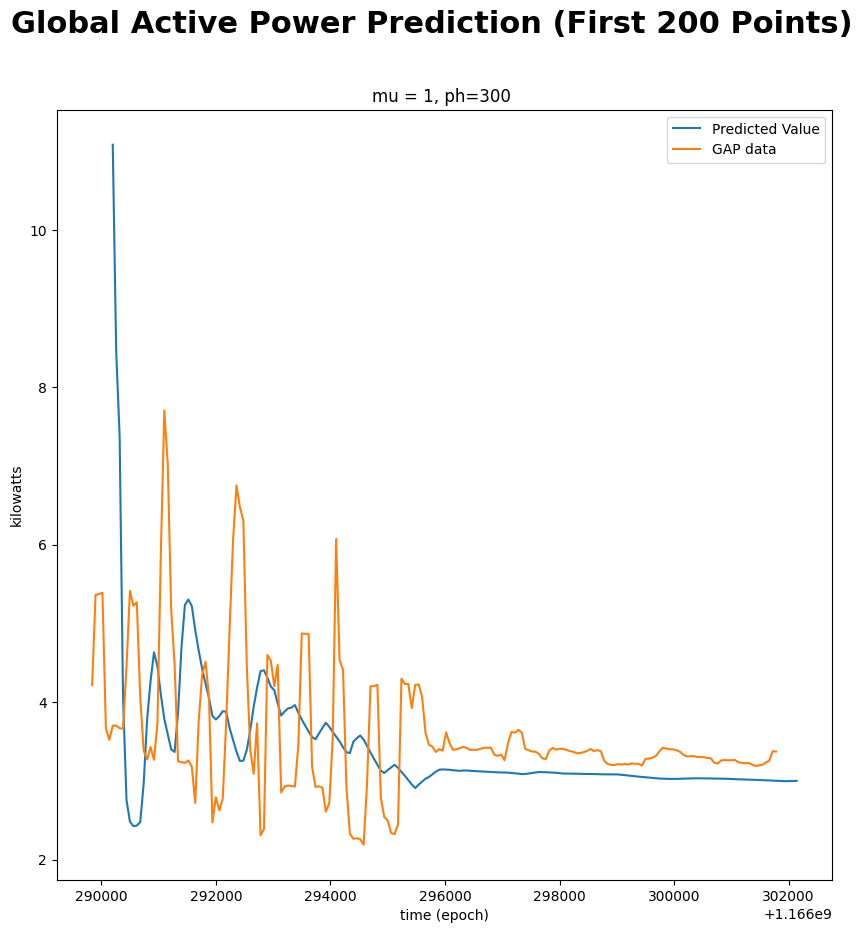

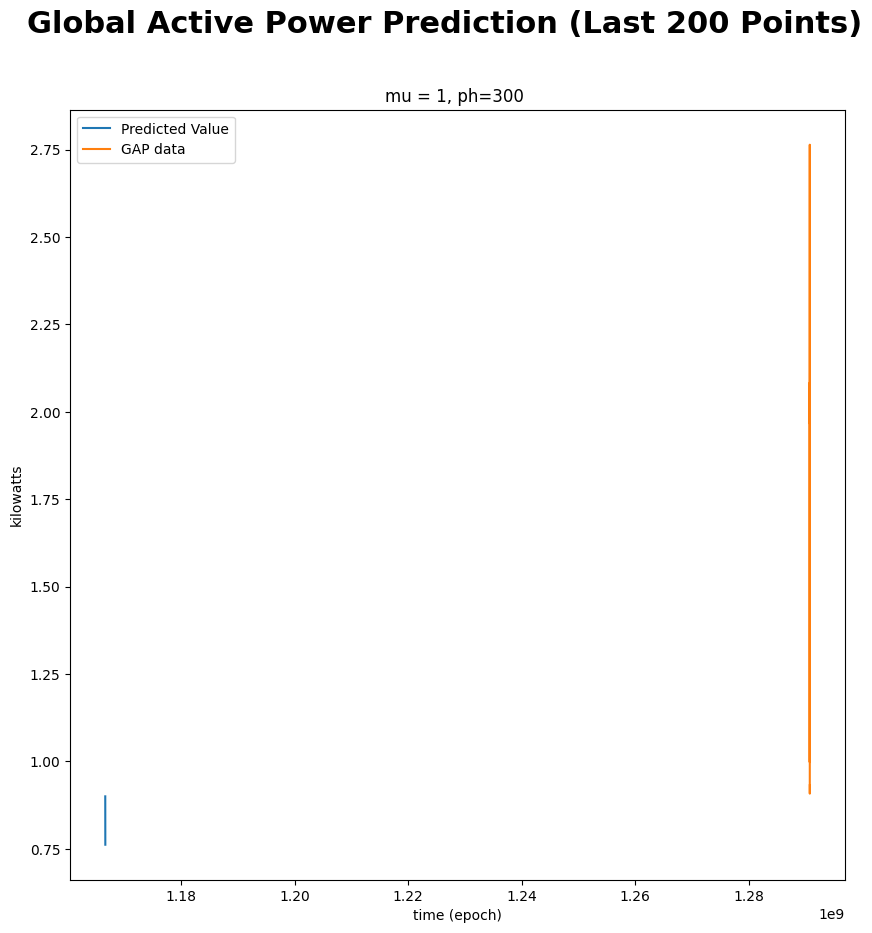

In [28]:
#Re-run prediction code for mu = 1

# Update mu value
mu = 1

# Re-initialize arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):  # start out with 2 leading datapoints
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
        
    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_
    
    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

# Calculate MSE of predictions
mse = mean_squared_error(ys.iloc[1:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with mu=1: {mse}')

# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200, 0], ys.iloc[0:200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

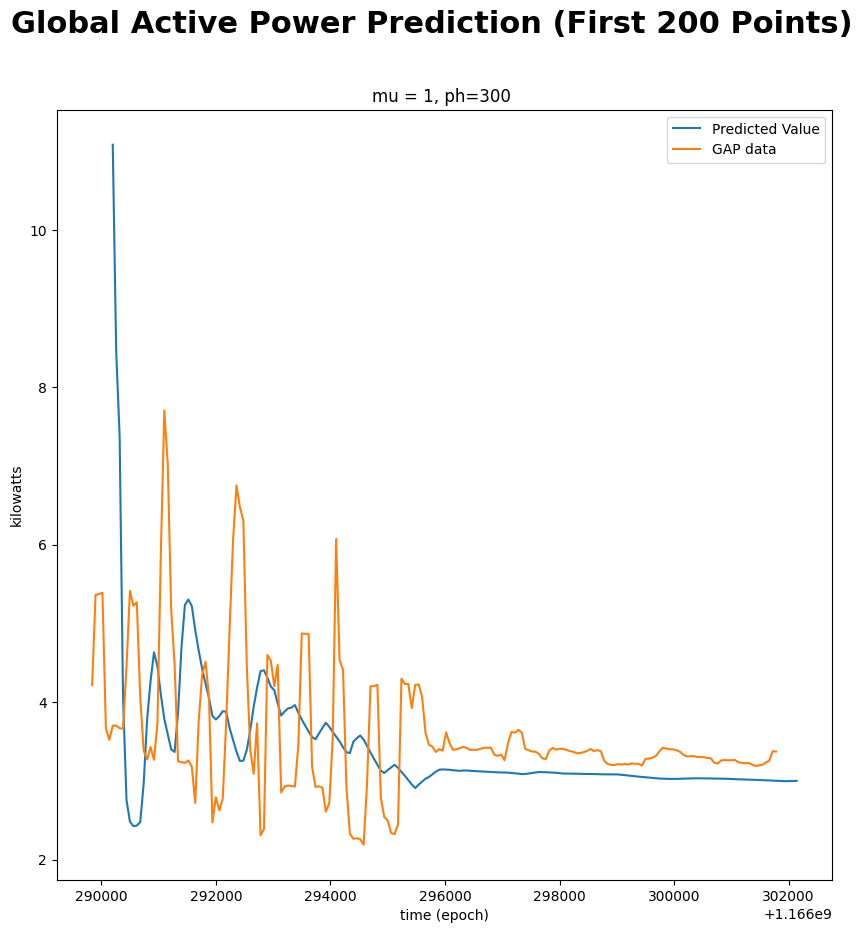

In [29]:
#Plot first 200 data points/predictions for mu = 1

# Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = 1, ph=%g ' % ph)
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

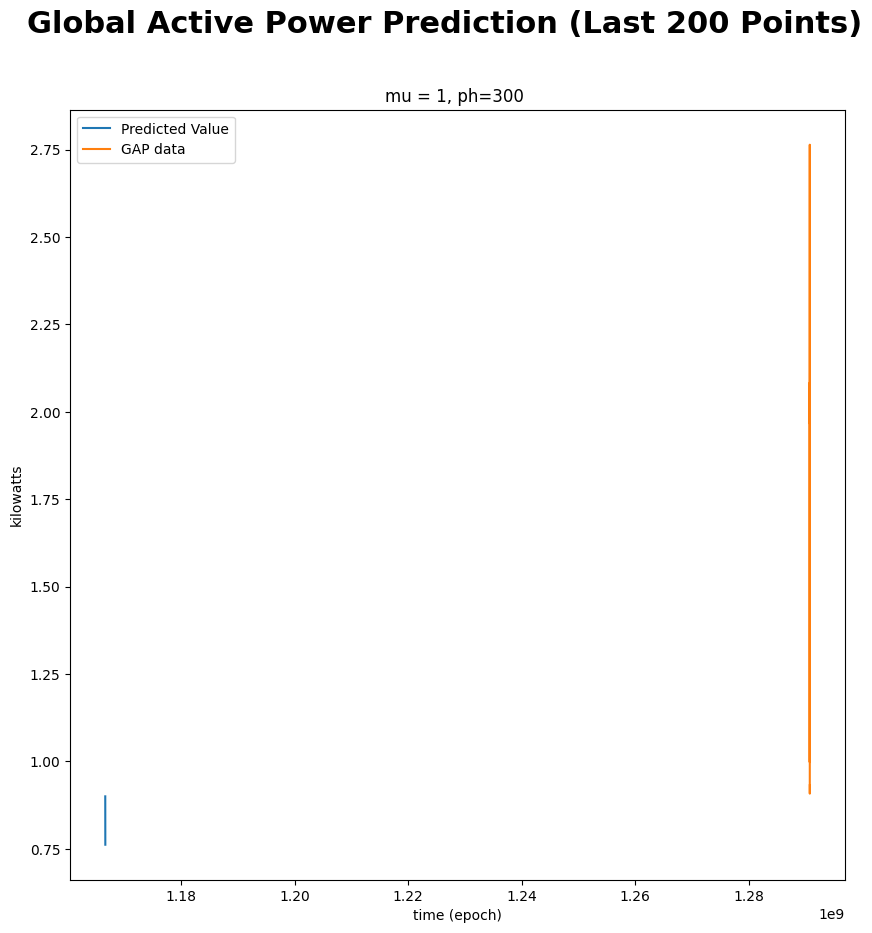

In [30]:
#Plot last 200 data points/predictions for mu = 1

# Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = 1, ph=%g ' % ph)
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [31]:
#Calculate MSE of predictions for mu = 1
mse = mean_squared_error(ys.iloc[1:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with mu=1: {mse}')

Mean Squared Error of predictions with mu=1: 1.3985130675798734


Mean Squared Error of predictions with mu=0.01: 10527723.369498555


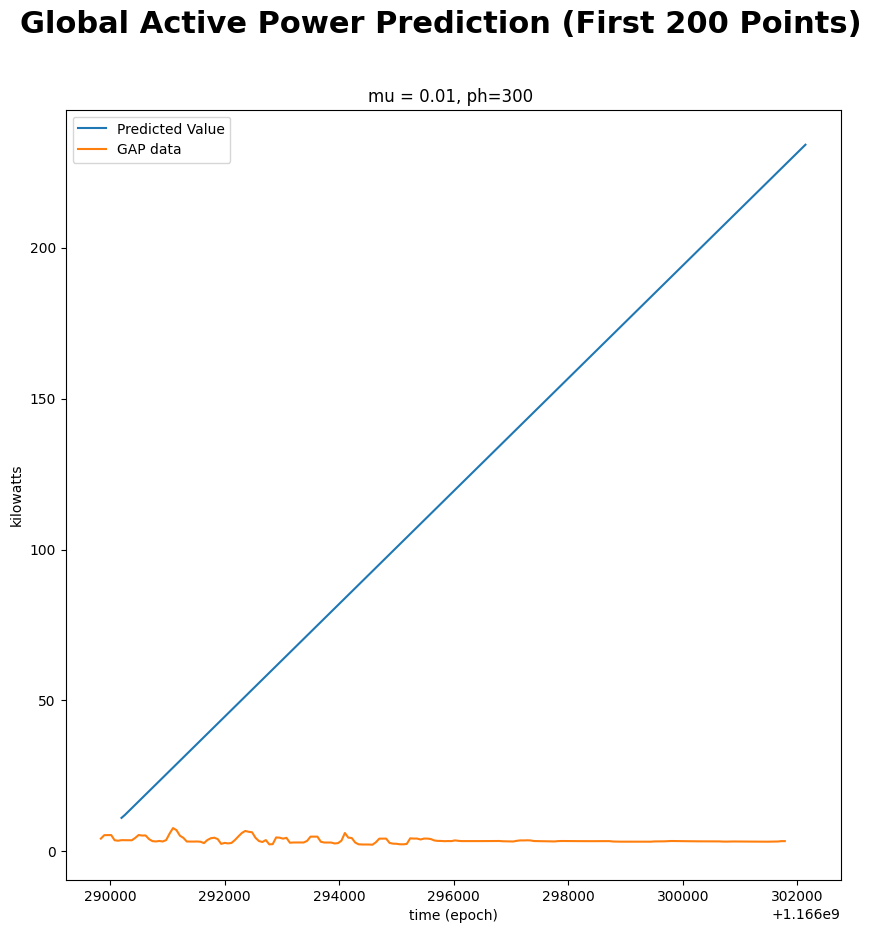

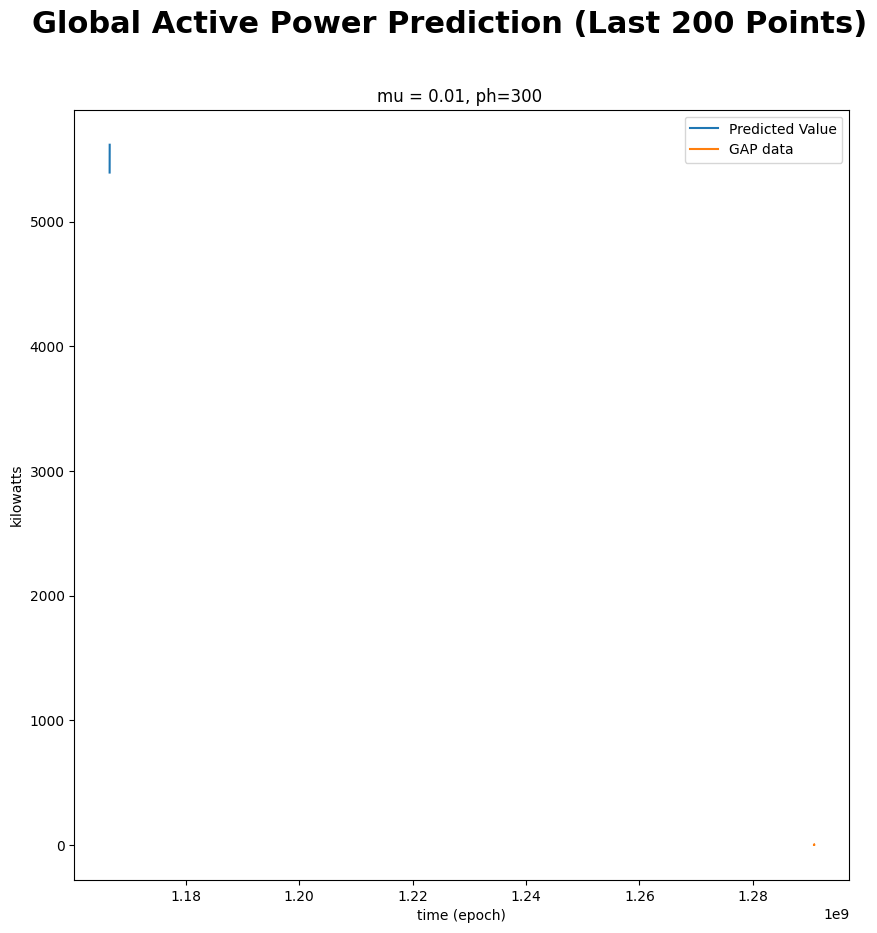

In [32]:
#Re-run prediction code for mu = 0.01

# Update mu value
mu = 0.01

# Re-initialize arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):  # start out with 2 leading datapoints
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
        
    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_
    
    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

# Calculate MSE of predictions
mse = mean_squared_error(ys.iloc[1:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with mu=0.01: {mse}')

# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = 0.01, ph=%g ' % ph)
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200, 0], ys.iloc[0:200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = 0.01, ph=%g ' % ph)
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

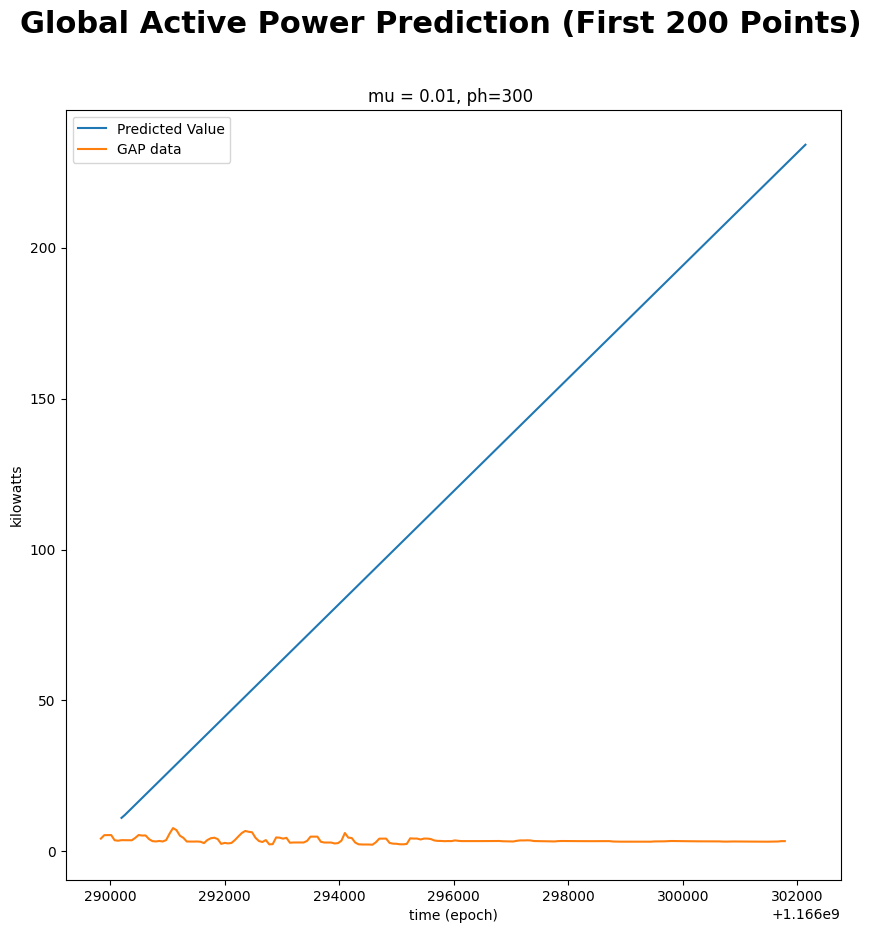

In [33]:
#Plot first 200 data points/predictions for mu = 0.01

# Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = 0.01, ph=%g ' % ph)
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

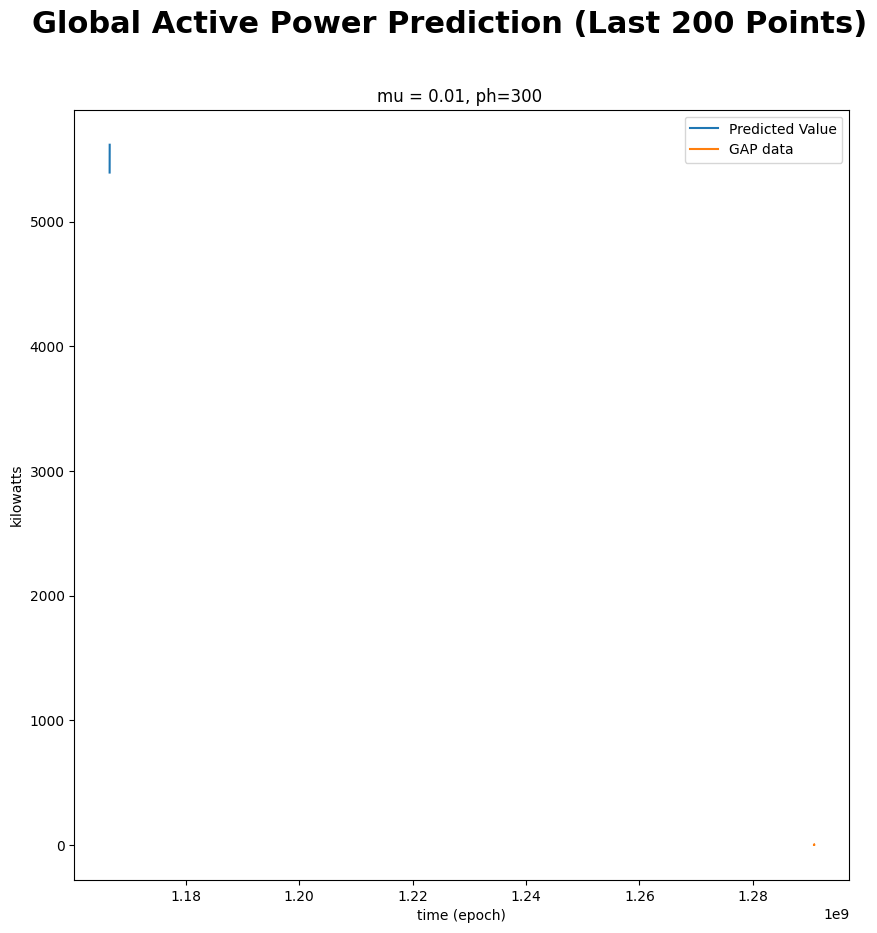

In [34]:
#Plot last 200 data points/predictions for mu = 0.01

# Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = 0.01, ph=%g ' % ph)
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [35]:
#Calculate MSE of predictions for mu = 0.01
mse = mean_squared_error(ys.iloc[1:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with mu=0.01: {mse}')

Mean Squared Error of predictions with mu=0.01: 10527723.369498555


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: 

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: 

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: 

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: 

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [ ]:
#add voltage to the x-variables in our dataset
ts = ?
ys = pd.DataFrame(df.Global_active_power)

ph = #5 minutes
ph_index = ?
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

Mean Squared Error of predictions with voltage: 35548.97389400162


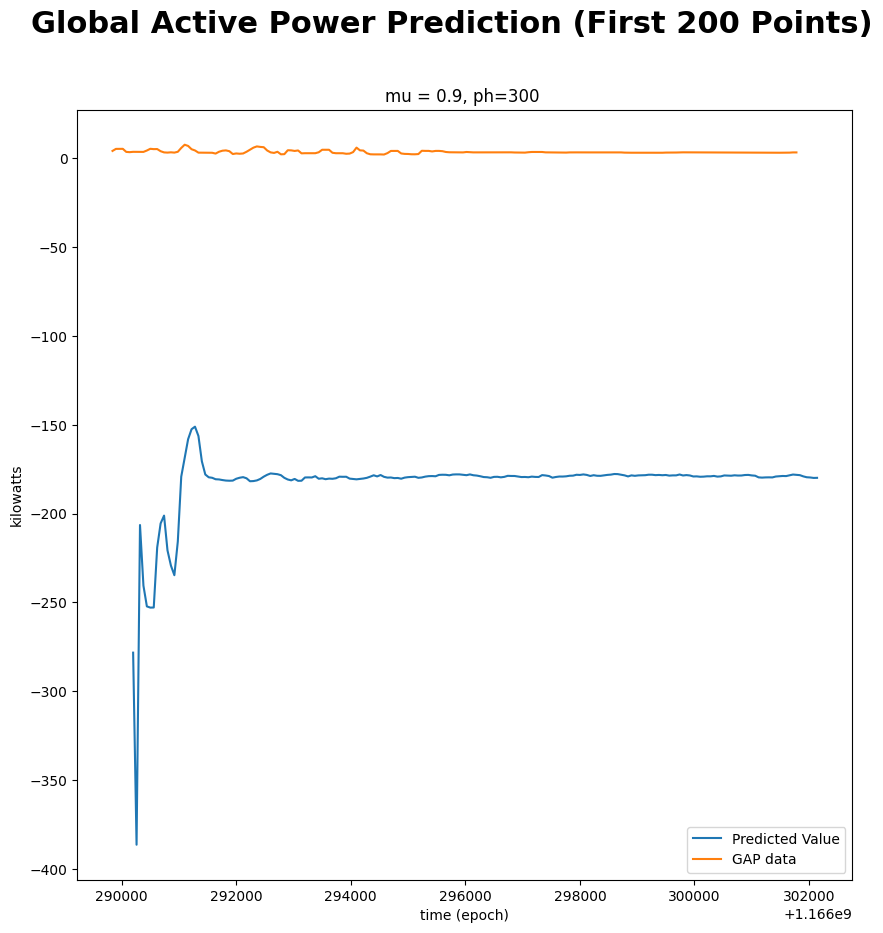

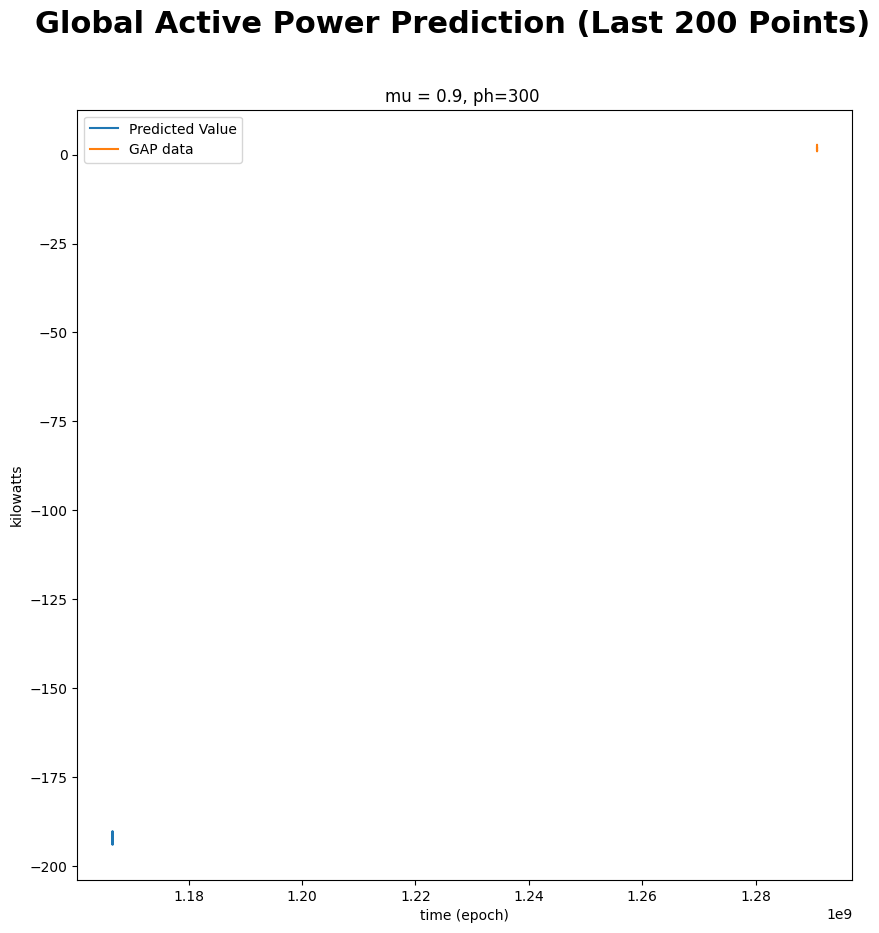

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add voltage to the x-variables in our dataset
ts = pd.DataFrame({'unix': df.unix, 'voltage': df.Voltage})
ys = pd.DataFrame(df.Global_active_power)

ph = 5 * 60  # 5 minutes in seconds
ph_index = ph / (df.unix[1] - df.unix[0])
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):  # start out with 2 leading datapoints
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
        
    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1] + ph
    yp = np.dot(m_tmp, tp) + q_tmp
      
    tp_pred[i-2] = tp['unix']    
    yp_pred[i-2] = yp

# Calculate MSE of predictions
mse = mean_squared_error(ys.iloc[1:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with voltage: {mse}')

# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

Mean Squared Error of predictions with voltage: 35548.97389400162


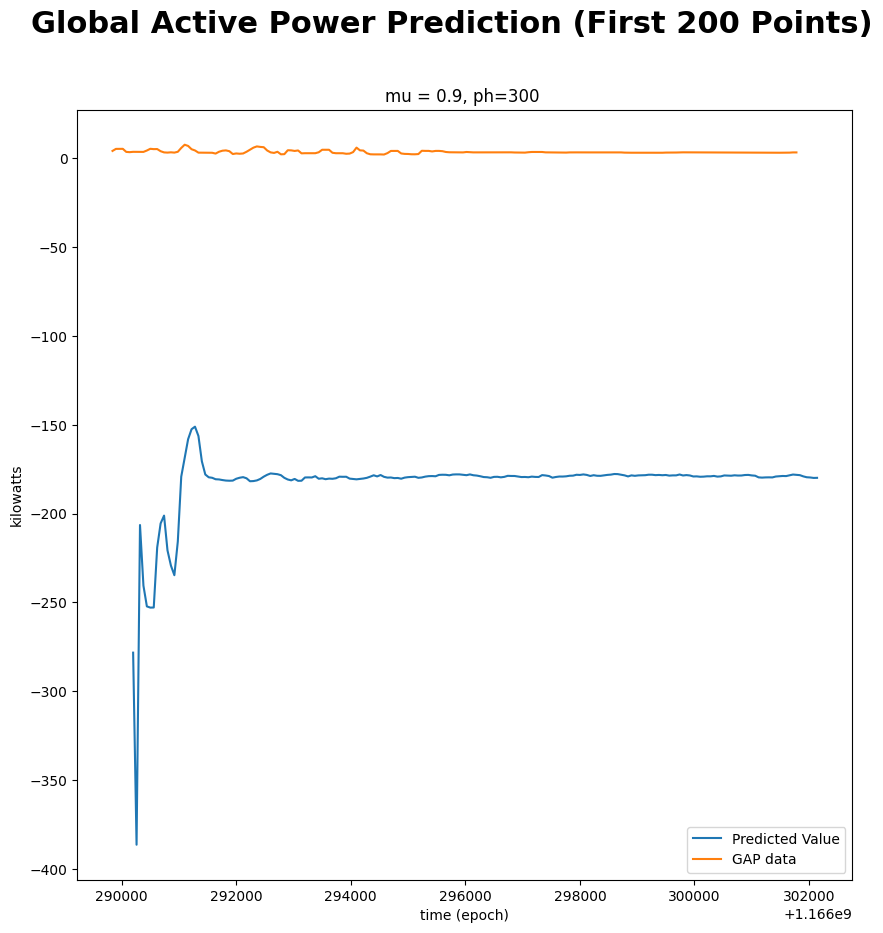

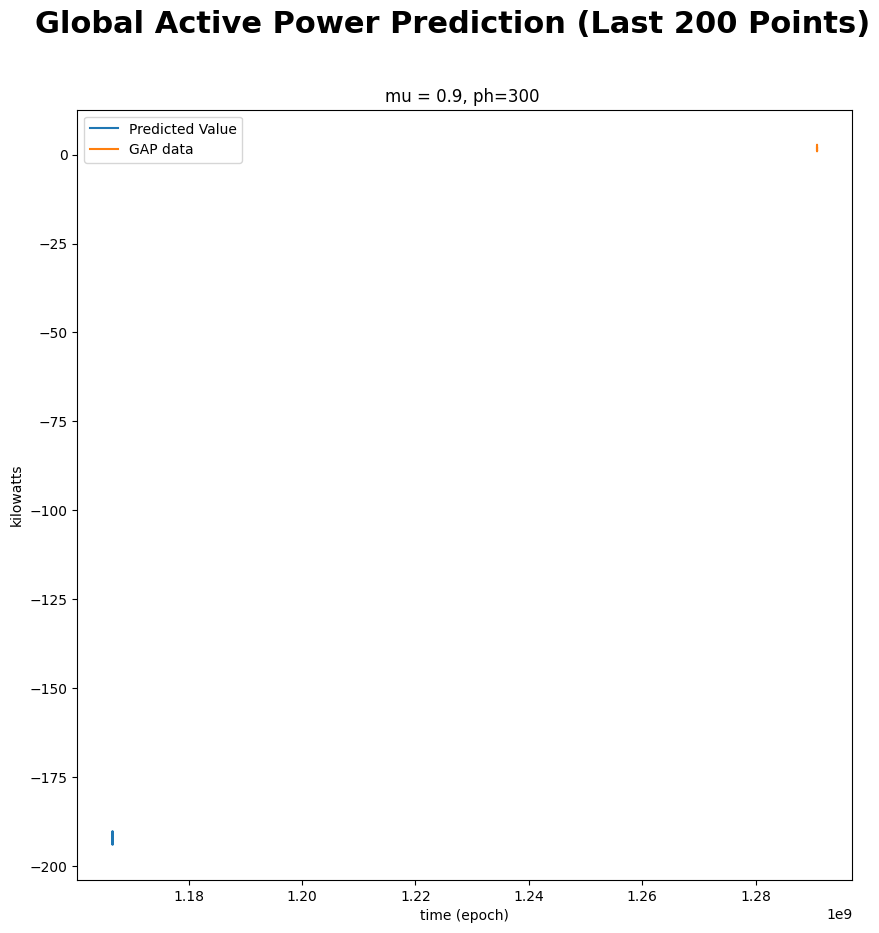

In [37]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add voltage to the x-variables in our dataset
ts = pd.DataFrame({'unix': df.unix, 'voltage': df.Voltage})
ys = pd.DataFrame(df.Global_active_power)

ph = 5 * 60  # 5 minutes in seconds
ph_index = ph / (df.unix[1] - df.unix[0])
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):  # start out with 2 leading datapoints
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
        
    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1] + ph
    yp = np.dot(m_tmp, tp) + q_tmp
      
    tp_pred[i-2] = tp['unix']    
    yp_pred[i-2] = yp

# Calculate MSE of predictions
mse = mean_squared_error(ys.iloc[1:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with voltage: {mse}')

# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

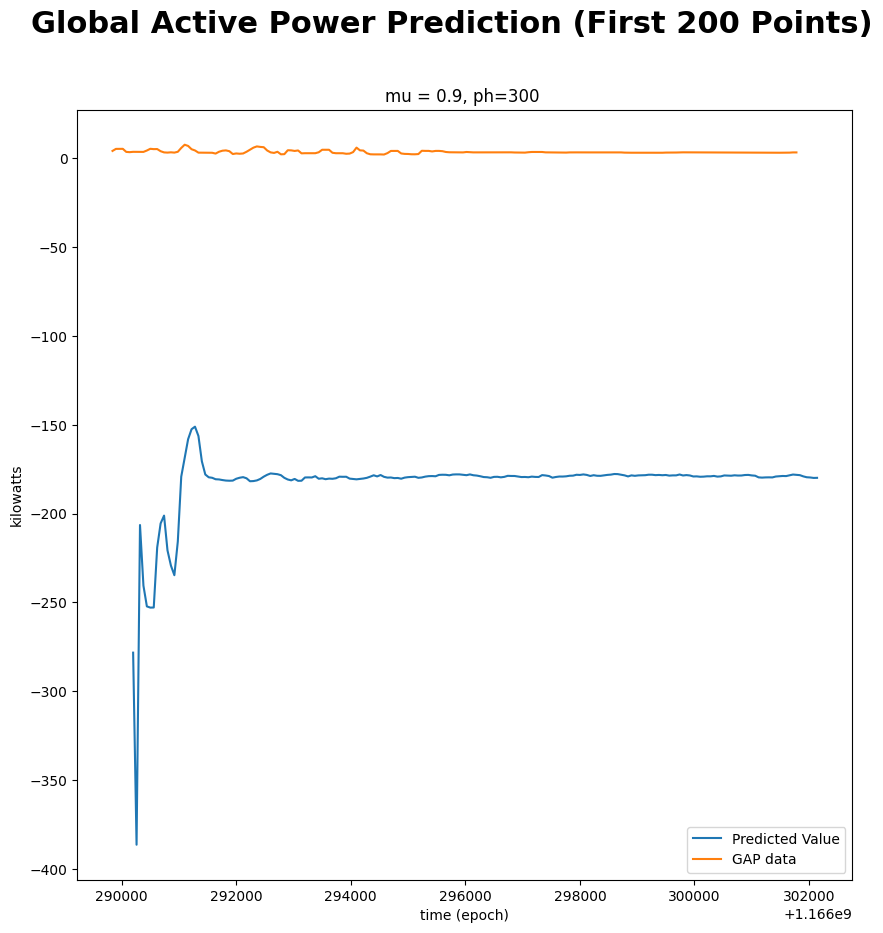

In [38]:
#Plot first 200 data points/predictions for the expanded dataset

# Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

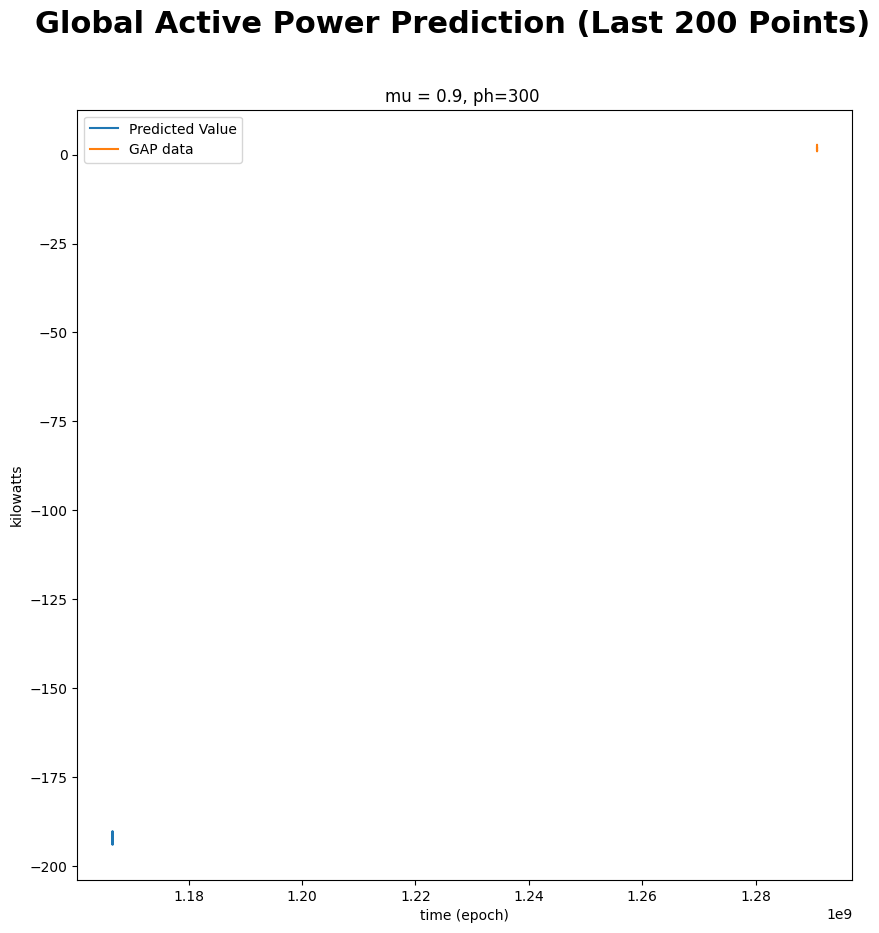

In [39]:
#Plot last 200 data points/predictions for the expanded data

# Plot last 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' % (mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [40]:
#Calculate MSE of predictions for the expanded data

from sklearn.metrics import mean_squared_error

# Calculate MSE of predictions for the expanded data
mse = mean_squared_error(ys.iloc[1:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with expanded data: {mse}')

Mean Squared Error of predictions with expanded data: 35548.97389400162


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: 

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: 

Mean Squared Error of predictions with moving window: 8532.94382301653


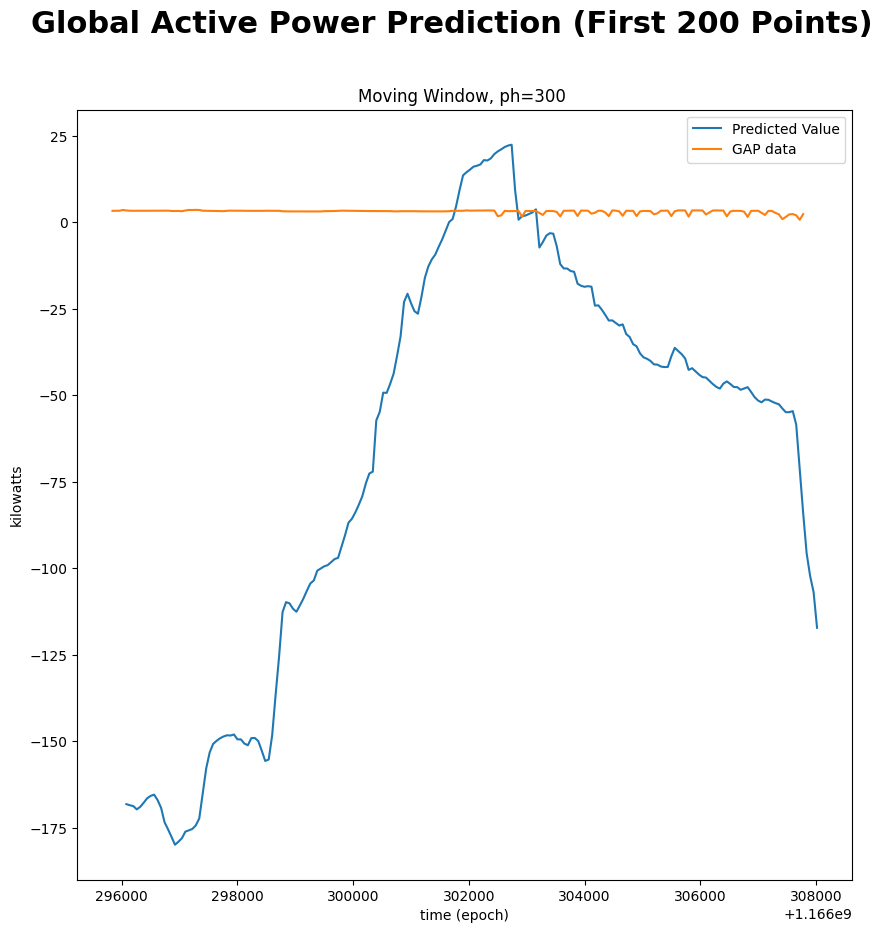

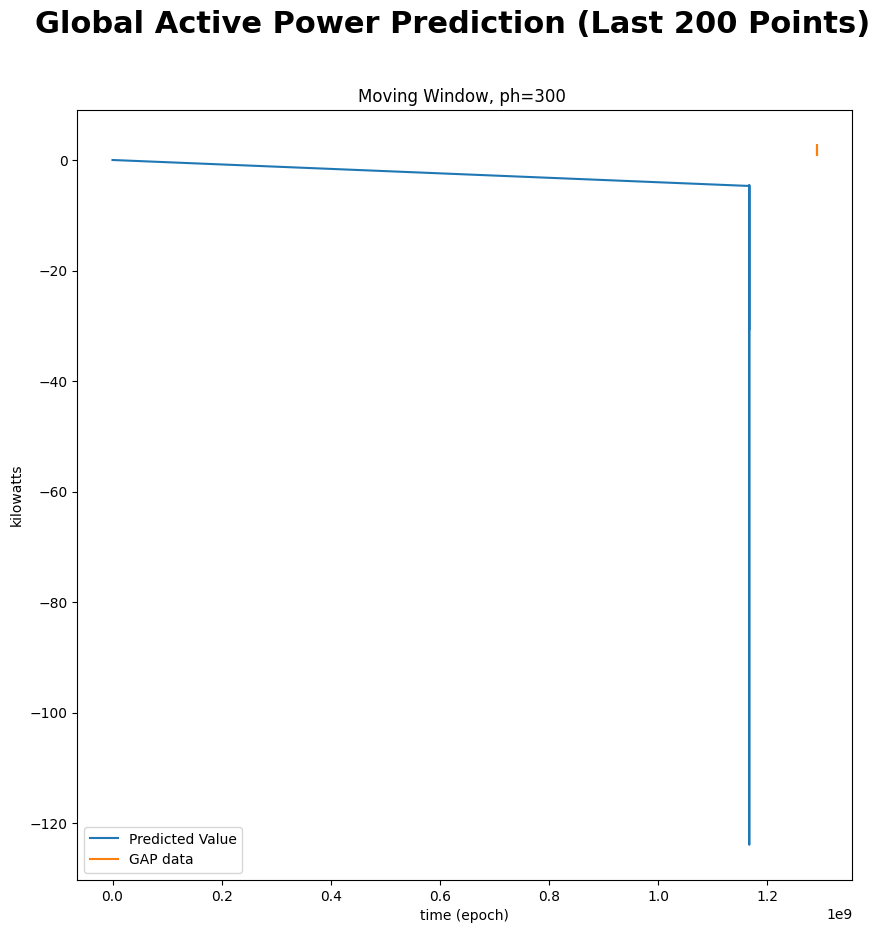

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create your alternative training data here
window_size = 100  # Define the size of the moving window

ts = pd.DataFrame({'unix': df.unix, 'voltage': df.Voltage})
ys = pd.DataFrame(df.Global_active_power)

ph = 5 * 60  # 5 minutes in seconds
ph_index = ph / (df.unix[1] - df.unix[0])
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(window_size, n_s+1):  # start out with window_size leading datapoints
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[i-window_size:i]
    ys_tmp = ys.iloc[i-window_size:i]
    
    # Perform linear regression on "available" data
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1] + ph
    yp = np.dot(m_tmp, tp) + q_tmp
      
    tp_pred[i-window_size] = tp['unix']    
    yp_pred[i-window_size] = yp

# Calculate MSE of predictions
mse = mean_squared_error(ys.iloc[window_size:n_s, 0].values, yp_pred[:n_s-window_size])
print(f'Mean Squared Error of predictions with moving window: {mse}')

# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('Moving Window, ph=%g ' % ph)
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[window_size:window_size+200, 0], ys.iloc[window_size:window_size+200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('Moving Window, ph=%g ' % ph)
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [ ]:
#create your alternative training data here


ph = #5 minutes
ph_index = 
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [42]:
#re-run the prediction code here

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Create your alternative training data here
window_size = 100  # Define the size of the moving window

ts = pd.DataFrame({'unix': df.unix, 'voltage': df.Voltage})
ys = pd.DataFrame(df.Global_active_power)

ph = 5 * 60  # 5 minutes in seconds
ph_index = ph / (df.unix[1] - df.unix[0])
mu = 0.9

# Let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-window_size) 
yp_pred = np.zeros(n_s-window_size)

# At every iteration of the for loop a new data sample is acquired
for i in range(window_size, n_s+1):  # start out with window_size leading datapoints
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[i-window_size:i]
    ys_tmp = ys.iloc[i-window_size:i]
    
    # Perform linear regression on "available" data
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp)
    
    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1] + ph
    yp = np.dot(m_tmp, tp) + q_tmp
      
    tp_pred[i-window_size] = tp['unix']    
    yp_pred[i-window_size] = yp

# Calculate MSE of predictions
mse = mean_squared_error(ys.iloc[window_size:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with moving window: {mse}')

# Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('Moving Window, ph=%g ' % ph)
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[window_size:window_size+200, 0], ys.iloc[window_size:window_size+200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

# Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('Moving Window, ph=%g ' % ph)
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

IndexError: index 4900 is out of bounds for axis 0 with size 4900

In [ ]:
#Plot first 200 data points/predictions for alternative model

# Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('Moving Window, ph=%g ' % ph)
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[window_size:window_size+200, 0], ys.iloc[window_size:window_size+200, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

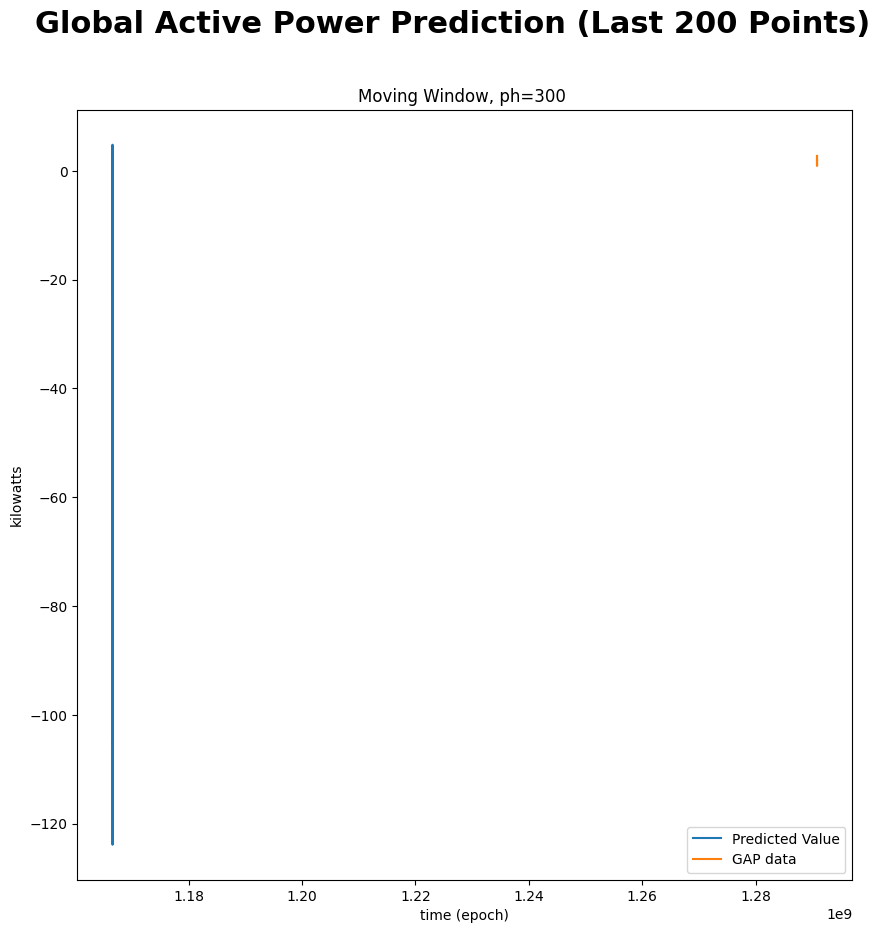

In [43]:
#Plot last 200 data points/predictions for alternative model

# Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 Points)', fontsize=22, fontweight='bold')
ax.set_title('Moving Window, ph=%g ' % ph)
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [44]:
#Calculate MSE of predictions for alternative model

from sklearn.metrics import mean_squared_error

# Calculate MSE of predictions for alternative model
mse = mean_squared_error(ys.iloc[window_size:n_s, 0].values, yp_pred)
print(f'Mean Squared Error of predictions with moving window: {mse}')

Mean Squared Error of predictions with moving window: 8532.94382301653


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.